jupyter:
  jupytext:
    text_representation:
      extension: .Rmd
      format_name: rmarkdown
      format_version: '1.2'
      jupytext_version: 1.17.1
  kernelspec:
    display_name: R
    language: R
    name: ir
---

### Peaks distribution and annotation — BAMPE narrowPeak files

In [1]:
# ============================================================================
# Load Required Libraries for Peak Analysis
# ============================================================================
# This section loads all necessary R packages for analyzing BAMPE narrowPeak files
# 
# Libraries overview:
# - ggplot2: Creating publication-quality plots
# - ChIPseeker: Annotating peaks to genomic features (genes, promoters, etc.)
# - TxDb/org.Hs.eg.db: Gene annotation databases for human genome (hg38)
# - GenomicRanges: Working with genomic coordinates and ranges
# - openxlsx: Writing results to Excel files
# - dplyr/tibble: Data manipulation and organization
# - ChIPpeakAnno: Additional peak annotation tools
# - GenomeInfoDb: Genome information utilities
# - clusterProfiler: Functional enrichment analysis (Gene Ontology, KEGG)
# - enrichplot: Visualization of enrichment results
# - AnnotationDbi: Interface to annotation databases

rm(list=ls())  # Clear workspace to start fresh
library(ggplot2)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(org.Hs.eg.db)
library(GenomicRanges)
library(openxlsx)
library(dplyr)
library(tibble)
library(ChIPpeakAnno)
library(GenomeInfoDb)
library(clusterProfiler)
library(enrichplot)
library(DOSE)
library(AnnotationDbi)

ChIPseeker v1.38.0

If you use ChIPseeker in published research, please cite:
Qianwen Wang, Ming Li, Tianzhi Wu, Li Zhan, Lin Li, Meijun Chen, Wenqin Xie, Zijing Xie, Erqiang Hu, Shuangbin Xu, Guangchuang Yu. Exploring epigenomic datasets by ChIPseeker. Current Protocols 2022, 2(10): e585



Loading required package: GenomicFeatures



Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: S4Vectors



Loading required package: stats4




Attaching package: ‘S4Vectors’




The following object is masked from ‘package:utils’:

    findMatches




The following objects are masked from ‘package:base’:

    expand.grid, I, unname




Loading required package: IRanges



Loading required package: GenomeInfoDb



Loading required package: GenomicRanges



Loading required package: AnnotationDbi



Loading required package: Biobase



Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.





Attaching package: ‘dplyr’




The following object is masked from ‘package:AnnotationDbi’:

    select




The following object is masked from ‘package:Biobase’:

    combine




The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union




The following object is masked from ‘package:GenomeInfoDb’:

    intersect




The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union




The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union




The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141




Attaching package: ‘clusterProfiler’




The following object is masked from ‘package:AnnotationDbi’:

    select




The following object is masked from ‘package:IRanges’:

    slice




The following object is masked from ‘package:S4Vectors’:

    rename




The following object is masked from ‘package:stats’:

    filter




DOSE v3.28.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609




## Configure paths and genome

In [2]:
# ============================================================================
# Step 1: Configure Paths and Genome Settings
# ============================================================================
# This section sets up the directories and genome information needed for the analysis.

# Define the INPUT directory containing narrowPeak files from MACS3
# narrowPeak files are text files produced by peak calling software (MACS3)
# Format: chr, start, end, name, score, strand, signalValue, pValue, qValue, peak
peak_dir <- "/cfs/klemming/projects/supr/uppstore2017150/Mattia/macs3/BAMPE"

# Define the OUTPUT directory where all results will be saved
# This includes: annotated peaks (Excel), enrichment results, and plots (PNG)
out_dir <- "/cfs/klemming/projects/supr/uppstore2017150/Mattia/Analysis"
dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

# ============================================================================
# Select the Reference Genome
# ============================================================================
# Options: 'hg38' (human, GRCh38) or 'mm10' (mouse)
# This determines which genome annotation database to use
genome <- "hg38"

# Load the appropriate transcriptome database (TxDb) based on genome choice
# TxDb contains information about gene structure (exons, promoters, intergenic regions, etc.)
txdb <- if (genome == "hg38") TxDb.Hsapiens.UCSC.hg38.knownGene else NULL

# Load the organism-specific annotation database (org.db)
# This database maps gene IDs to gene symbols, descriptions, and GO terms
orgdb <- if (genome == "hg38") org.Hs.eg.db else NULL

# Store as string name for use in annotatePeak function
anno_db <- if (genome == "hg38") "org.Hs.eg.db" else "org.Mm.eg.db"

# Set organism code for KEGG pathway analysis
# 'hsa' = Homo sapiens (human), 'mmu' = Mus musculus (mouse)
org_kegg <- if (genome == "hg38") "hsa" else "mmu"

## Read narrowPeak files, resize summits and annotate

Processing: OPC_LUZP2_nanoCT



>> preparing features information...		 2026-02-08 09:15:22 PM 
>> identifying nearest features...		 2026-02-08 09:15:23 PM 
>> calculating distance from peak to TSS...	 2026-02-08 09:15:25 PM 
>> assigning genomic annotation...		 2026-02-08 09:15:25 PM 
>> adding gene annotation...			 2026-02-08 09:15:57 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2026-02-08 09:15:57 PM 
>> done...					 2026-02-08 09:15:57 PM 


'select()' returned 1:many mapping between keys and columns



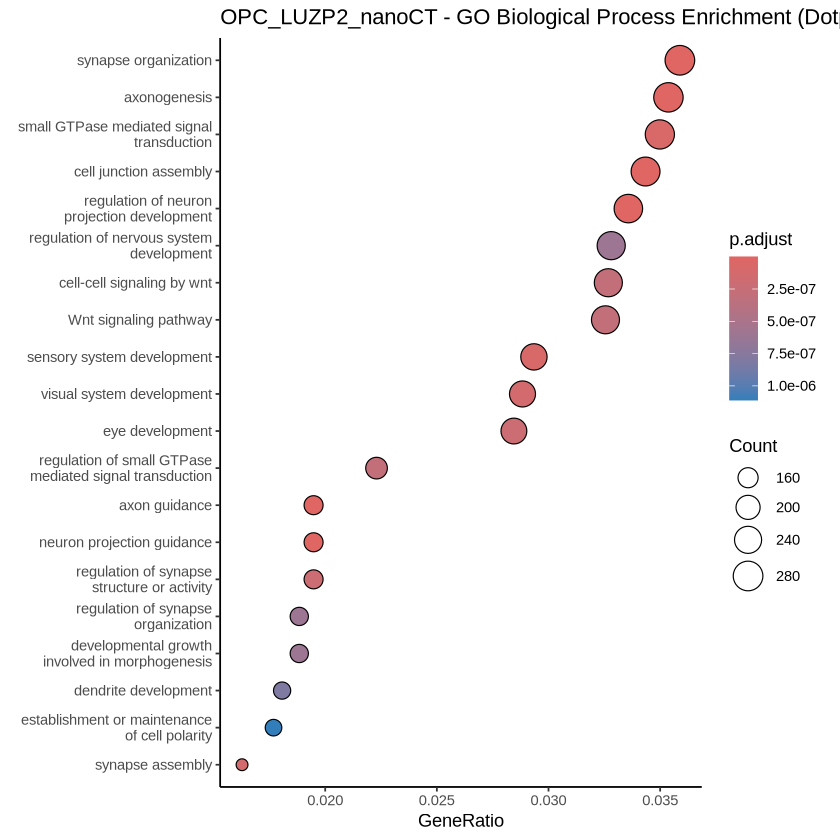

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...



Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



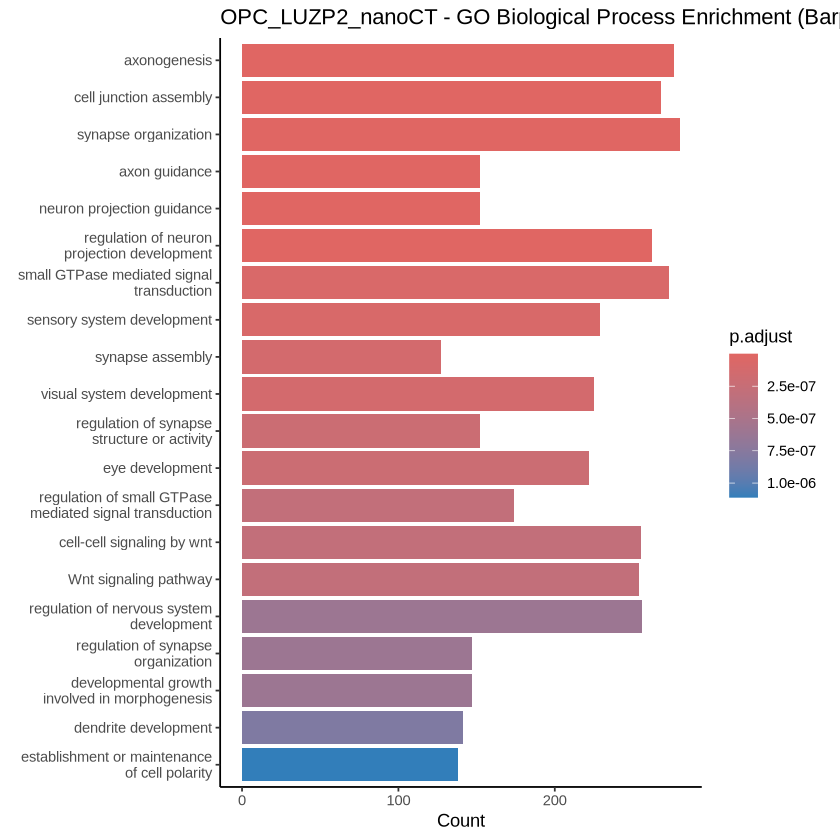

Processing: OPC_SOX10_nanoCT



>> preparing features information...		 2026-02-08 09:16:49 PM 
>> identifying nearest features...		 2026-02-08 09:16:49 PM 
>> calculating distance from peak to TSS...	 2026-02-08 09:16:50 PM 
>> assigning genomic annotation...		 2026-02-08 09:16:50 PM 
>> adding gene annotation...			 2026-02-08 09:16:54 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2026-02-08 09:16:54 PM 
>> done...					 2026-02-08 09:16:54 PM 


'select()' returned 1:many mapping between keys and columns



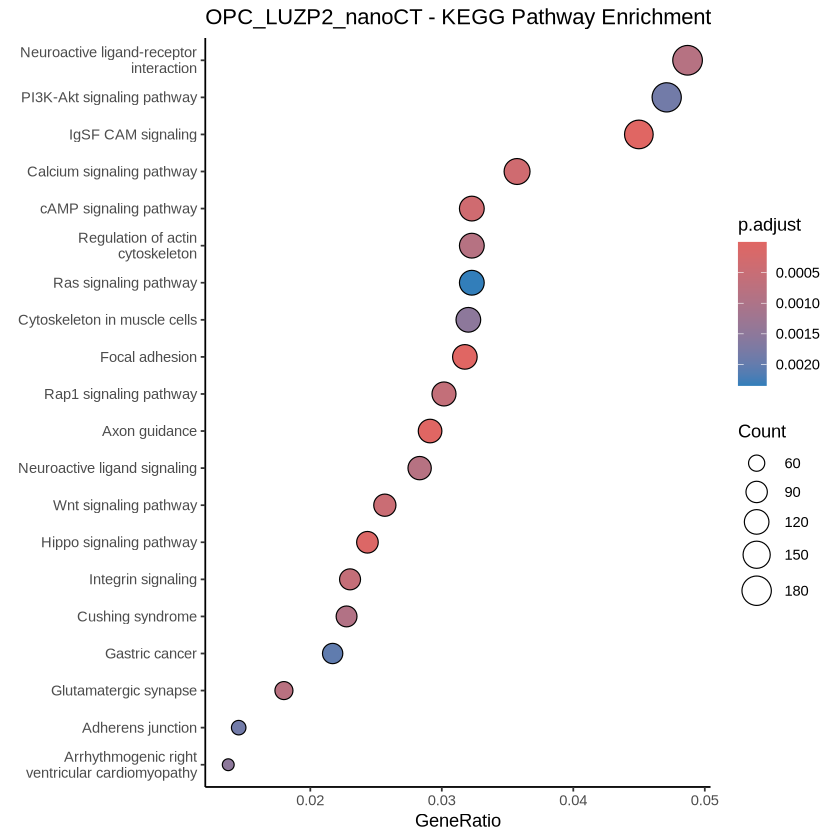

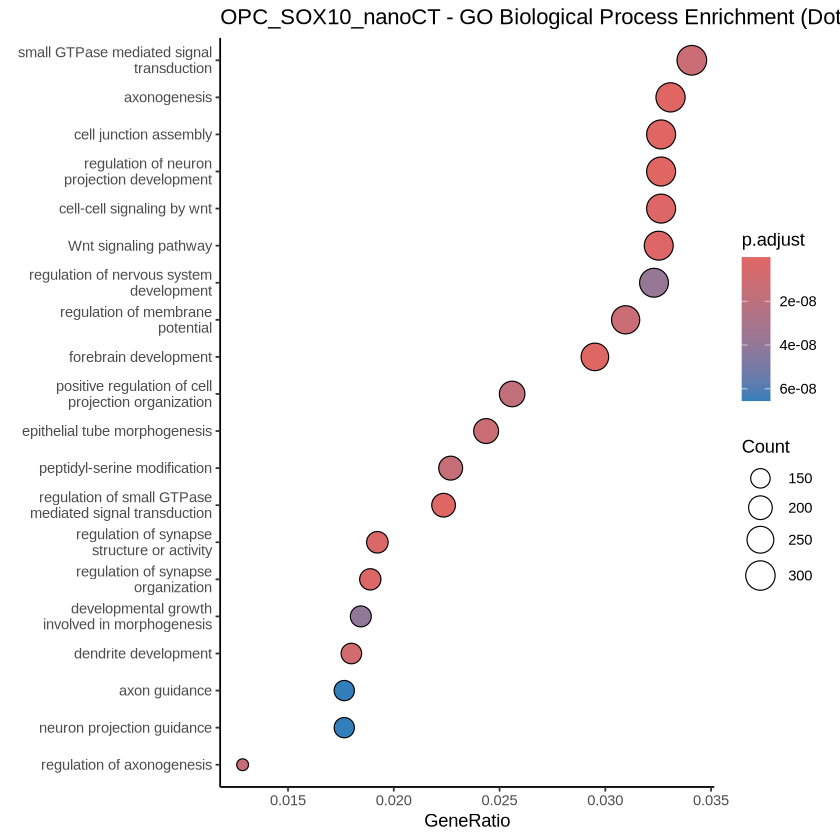

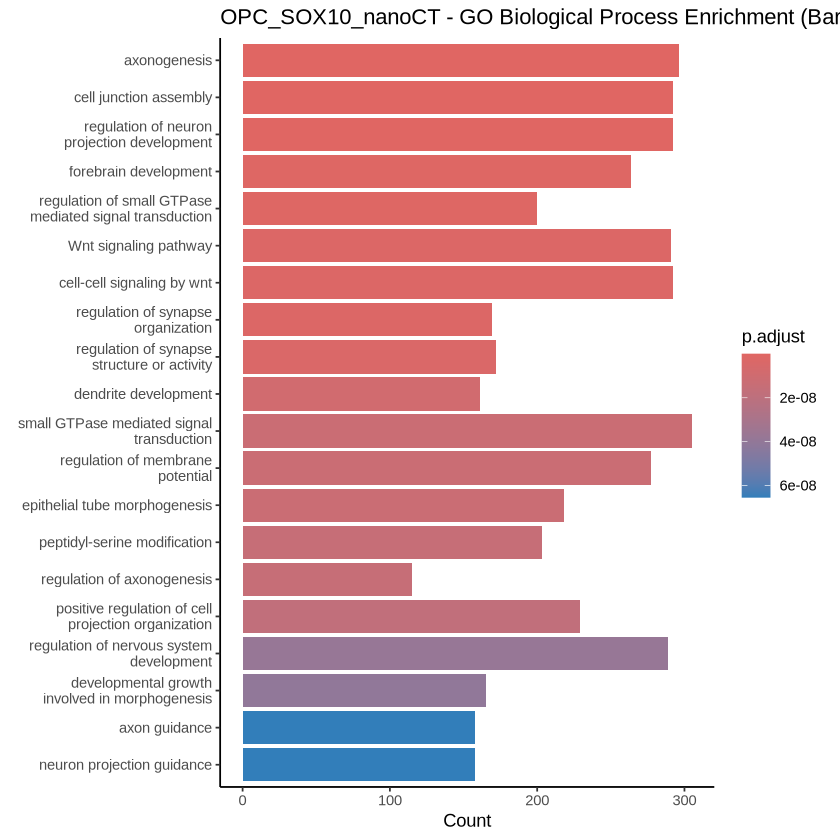

Processing: OPC_TSC22_nanoCT



>> preparing features information...		 2026-02-08 09:17:21 PM 
>> identifying nearest features...		 2026-02-08 09:17:21 PM 
>> calculating distance from peak to TSS...	 2026-02-08 09:17:21 PM 
>> assigning genomic annotation...		 2026-02-08 09:17:21 PM 
>> adding gene annotation...			 2026-02-08 09:17:25 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2026-02-08 09:17:25 PM 
>> done...					 2026-02-08 09:17:25 PM 


'select()' returned 1:1 mapping between keys and columns



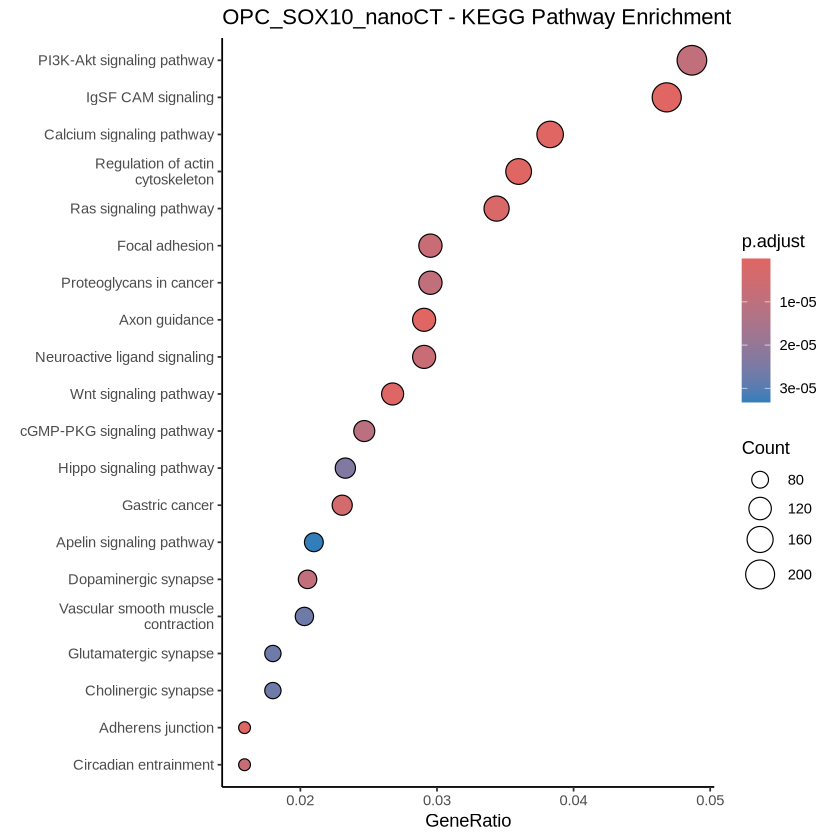

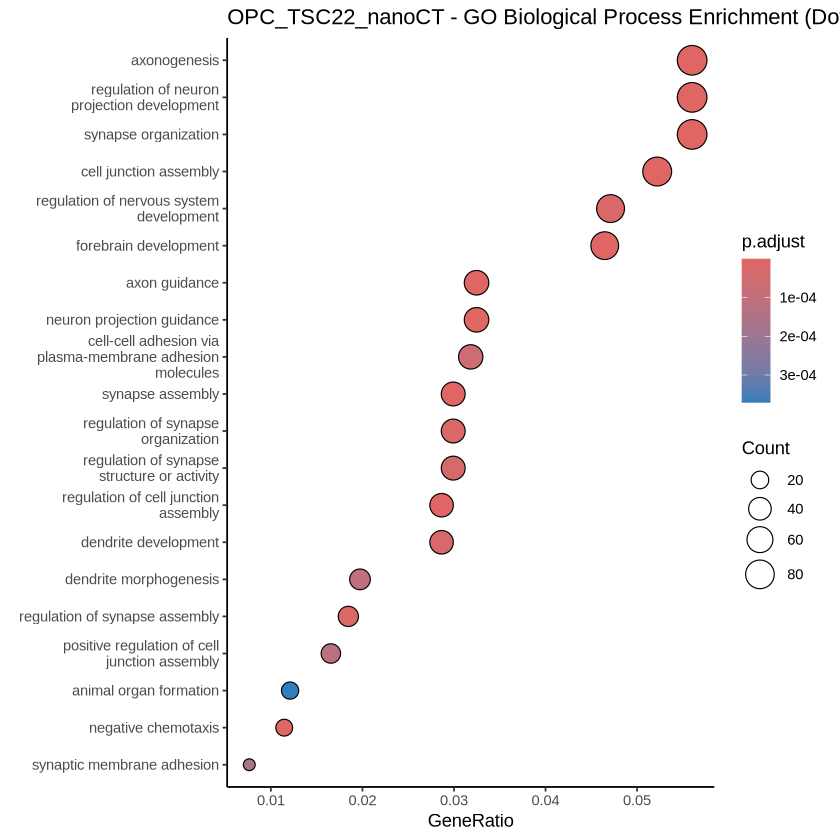

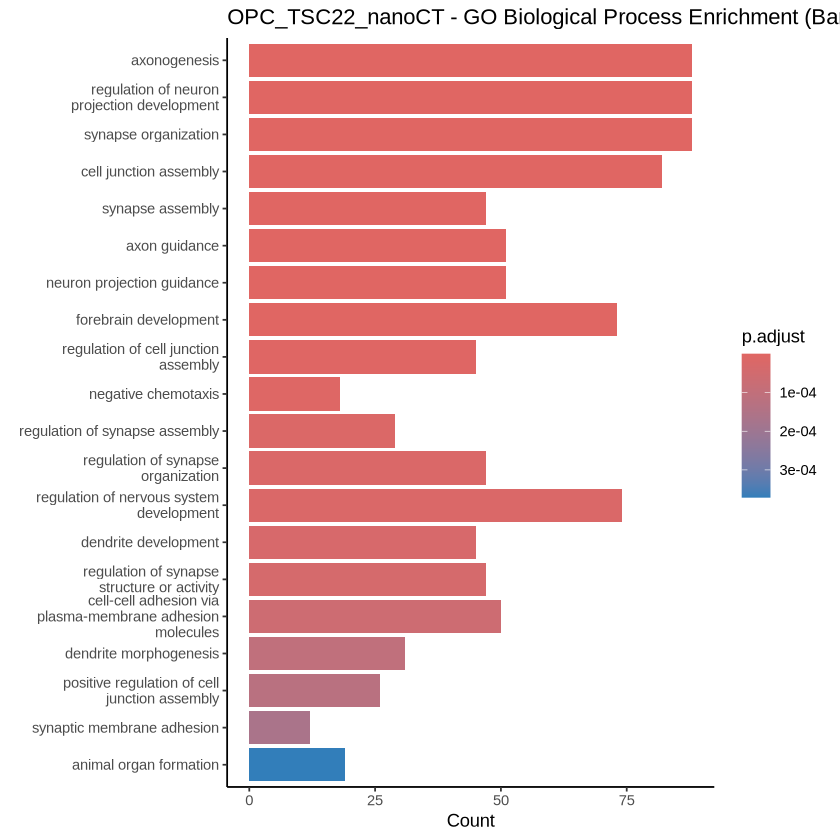

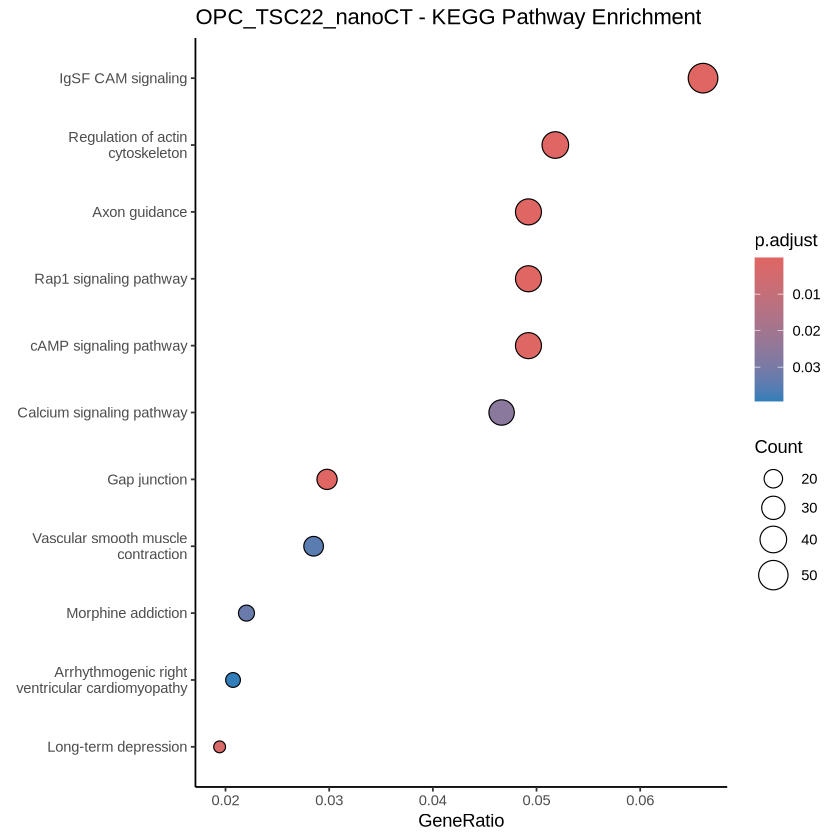

In [3]:
# ============================================================================
# Step 2: Read narrowPeak Files, Process Peaks, and Annotate Them
# ============================================================================
# This section is the core of the analysis:
# 1. Reads all narrowPeak files from the BAMPE directory
# 2. Converts peaks to GRanges objects (genomic range format)
# 3. Annotates peaks to nearby genes using ChIPseeker
# 4. Performs functional enrichment analysis on the annotated genes

# Find all narrowPeak files in the input directory
peak_files <- list.files(peak_dir, pattern = "\\.narrowPeak$", full.names = TRUE)
if (length(peak_files) == 0) stop("No .narrowPeak files found in: ", peak_dir)

# Create empty lists to store results
peak_list <- list()          # Stores GRanges objects for each sample
feature_tables <- list()     # Stores feature distribution counts
annotated_peaks_list <- list()  # Stores annotated peak information

# ============================================================================
# Loop through each narrowPeak file and process it
# ============================================================================
for (pf in peak_files) {
  # Extract sample name from filename (removes "_peaks.narrowPeak" suffix)
  sample <- basename(pf) %>% gsub("_peaks\\.narrowPeak$|\\.narrowPeak$", "", .)
  message("Processing: ", sample)
  
  # --------- Read narrowPeak File ---------
  # narrowPeak format (tab-separated):
  # col1=chr, col2=start, col3=end, col4=name, col5=score, col6=strand
  # col7=signalValue, col8=pValue, col9=qValue, col10=peak(relative peak position)
  dat <- read.table(pf, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
  colnames(dat)[1:10] <- c("chr","start","end","name","score","strand","signalValue","pValue","qValue","peak")
  
  # --------- Convert Peaks to Genomic Ranges ---------
  # Calculate the summit position: start coordinate + offset to peak (col10)
  # The peak column contains the offset from the start position to the actual peak
  dat$summit <- dat$start + dat$peak
  
  # Create a GRanges object from summit positions
  # GRanges is a standardized format for storing genomic coordinates
  # We resize to 500bp window around the summit (250bp on each side)
  summits <- GRanges(seqnames = dat$chr, ranges = IRanges(start = dat$summit, end = dat$summit))
  summits <- resize(summits, width = 500, fix = "center")
  
  # --------- Annotate Peaks to Genomic Features ---------
  # ChIPseeker::annotatePeak assigns each peak to the nearest gene
  # and identifies the genomic region type (promoter, exon, intergenic, etc.)
  ann <- annotatePeak(summits, TxDb = txdb, annoDb = anno_db, tssRegion = c(-3000, 3000))
  ann_df <- as.data.frame(ann)
  
  # Save the full annotation results to Excel
  write.xlsx(ann_df, file = file.path(out_dir, paste0(sample, "_annotated_peaks.xlsx")))
  annotated_peaks_list[[sample]] <- ann_df
  
  # ============================================================================
  # Functional Enrichment Analysis
  # ============================================================================
  # Extract unique gene symbols from the peak annotations
  # These are the genes that have peaks associated with them
  genes_sym <- unique(na.omit(ann_df$SYMBOL))
  genes_sym <- genes_sym[genes_sym != "0" & genes_sym != ""]
  
  # Only perform enrichment if we have genes and the organism database is available
  if (length(genes_sym) > 0 && !is.null(orgdb)) {
    # Convert gene SYMBOLs to ENTREZ IDs (required for enrichment databases)
    # ENTREZ IDs are standardized identifiers used by GO and KEGG
    gene_map <- tryCatch({ 
      bitr(genes_sym, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb) 
    }, error = function(e) NULL)
    
    if (!is.null(gene_map) && nrow(gene_map) > 0) {
      entrez_ids <- unique(gene_map$ENTREZID)
      
      # --------- Gene Ontology (GO) Biological Process Enrichment ---------
      # GO BP terms describe biological processes (e.g., "cell division", "immune response")
      # enrichGO tests whether genes with peaks are enriched for specific GO terms
      # beyond what would be expected by chance
      ego <- tryCatch({
        enrichGO(gene = entrez_ids, OrgDb = orgdb, keyType = "ENTREZID",
                 ont = "BP",            # Biological Process (other options: MF, CC)
                 pAdjustMethod = "BH",  # Multiple test correction (Benjamini-Hochberg)
                 pvalueCutoff = 0.05)   # Significance threshold
      }, error = function(e) NULL)
      
      # If enrichment results were found, generate plots and save results
      if (!is.null(ego) && nrow(as.data.frame(ego)) > 0) {
        # Save GO enrichment results to Excel
        write.xlsx(as.data.frame(ego), file = file.path(out_dir, paste0(sample, "_GO_BP_enrichment.xlsx")))
        
        # Create and display dotplot
        # Dotplot: x-axis = gene ratio in pathway, y-axis = GO terms, color = p-value, size = gene count
        ego_dot <- dotplot(ego, showCategory = 20) + 
              ggtitle(paste0(sample, " - GO Biological Process Enrichment (Dotplot)")) +
              theme_classic()
        print(ego_dot)  # Display in notebook
        # Save to file
        ggsave(file.path(out_dir, paste0(sample, "_GO_BP_dotplot.png")), 
               plot = ego_dot, width = 10, height = 8, dpi = 300)
        
        # Create and display barplot
        # Barplot: shows enrichment count for top GO terms
        ego_bar <- barplot(ego, showCategory = 20) + 
              ggtitle(paste0(sample, " - GO Biological Process Enrichment (Barplot)")) +
              theme_classic()
        print(ego_bar)  # Display in notebook
        # Save to file
        ggsave(file.path(out_dir, paste0(sample, "_GO_BP_barplot.png")), 
               plot = ego_bar, width = 10, height = 8, dpi = 300)
      } else {
        message("No enriched GO BP terms for sample: ", sample)
      }
      
      # --------- KEGG Pathway Enrichment (Optional) ---------
      # KEGG pathways describe biological signaling and metabolic networks
      kk <- tryCatch({ 
        enrichKEGG(gene = entrez_ids, organism = org_kegg, pvalueCutoff = 0.05) 
      }, error = function(e) NULL)
      
      if (!is.null(kk) && nrow(as.data.frame(kk)) > 0) {
        # Save KEGG enrichment results to Excel
        write.xlsx(as.data.frame(kk), file = file.path(out_dir, paste0(sample, "_KEGG_enrichment.xlsx")))
        
        # Create and display KEGG dotplot
        kk_dot <- dotplot(kk, showCategory = 20) + 
              ggtitle(paste0(sample, " - KEGG Pathway Enrichment")) +
              theme_classic()
        print(kk_dot)  # Display in notebook
        # Save to file
        ggsave(file.path(out_dir, paste0(sample, "_KEGG_dotplot.png")), 
               plot = kk_dot, width = 10, height = 8, dpi = 300)
      } else {
        message("No KEGG terms or KEGG failed for sample: ", sample)
      }
    } else {
      message("No ENTREZ ID mapping for sample: ", sample)
    }
  } else {
    message("No gene SYMBOLs found for sample: ", sample)
  }
  
  # ============================================================================
  # Summarize Feature Distribution
  # ============================================================================
  # Count the number of peaks in each genomic feature type
  # This helps understand WHERE peaks are located in the genome
  ft <- as.data.frame(table(gsub(" \\(.+", "", ann_df$annotation)))
  colnames(ft) <- c("Feature","Freq")
  feature_tables[[sample]] <- ft
  
  # Store GRanges object for later use (e.g., overlap analysis)
  peak_list[[sample]] <- summits
}

## Per-sample pie charts and combined distribution

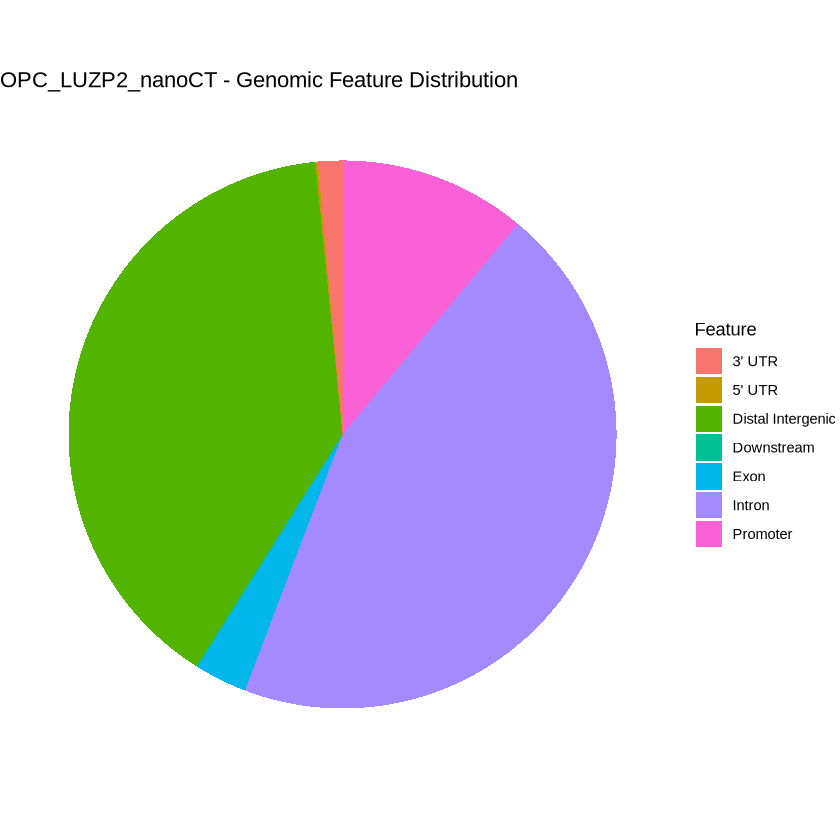

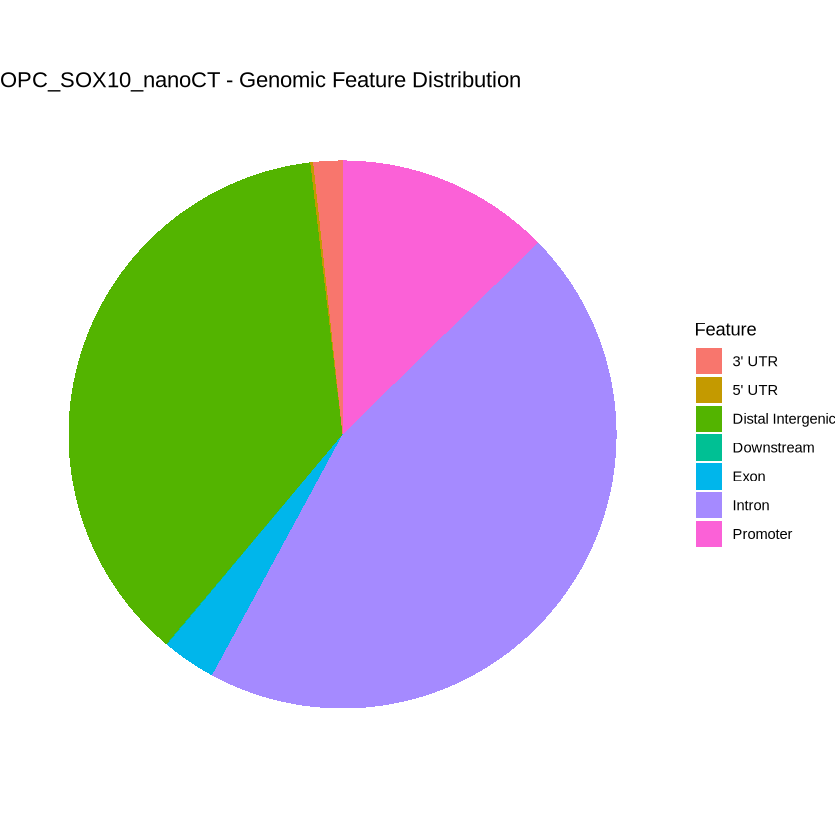

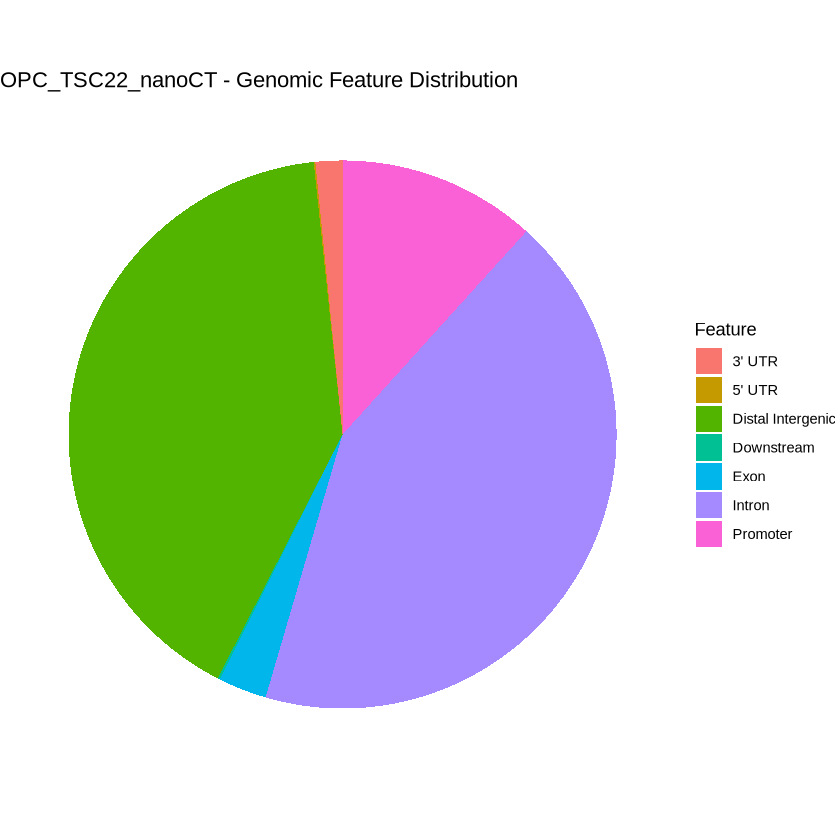

Missing totalTest! totalTest is required for HyperG test. 
If totalTest is missing, pvalue will be calculated by estimating 
the total binding sites of encoding region of human.
totalTest = humanGenomeSize * (2%(codingDNA) + 
             1%(regulationRegion)) / ( 2 * averagePeakWidth )
          = 3.3e+9 * 0.03 / ( 2 * averagePeakWidth)
          = 5e+7 /averagePeakWidth



INFO [2026-02-08 21:17:52] $cat.cex
INFO [2026-02-08 21:17:52] [1] 1
INFO [2026-02-08 21:17:52] 
INFO [2026-02-08 21:17:52] $cat.col
INFO [2026-02-08 21:17:52] [1] "black"
INFO [2026-02-08 21:17:52] 
INFO [2026-02-08 21:17:52] $cat.fontface
INFO [2026-02-08 21:17:52] [1] "plain"
INFO [2026-02-08 21:17:52] 
INFO [2026-02-08 21:17:52] $cat.fontfamily
INFO [2026-02-08 21:17:52] [1] "serif"
INFO [2026-02-08 21:17:52] 
INFO [2026-02-08 21:17:52] $x
INFO [2026-02-08 21:17:52] $x$OPC_LUZP2_nanoCT
INFO [2026-02-08 21:17:52]     [1]  67597  67598  67599  67600  67601  67602  67603  67604  67605  67606
INFO [2026-02-08 21:17:52]    [11]  67607  67608  67609  67610  67611  67612  67613  67614  67615  67616
INFO [2026-02-08 21:17:52]    [21]  67617  67618  67619  67620  67621  67622  67623  67624  67625  67626
INFO [2026-02-08 21:17:52]    [31]  67627  67628  67629  67630  67631  67632  67633  67634  67635  67636
INFO [2026-02-08 21:17:52]    [41]  67637  67638  67639  67640  67641  67642  67643  

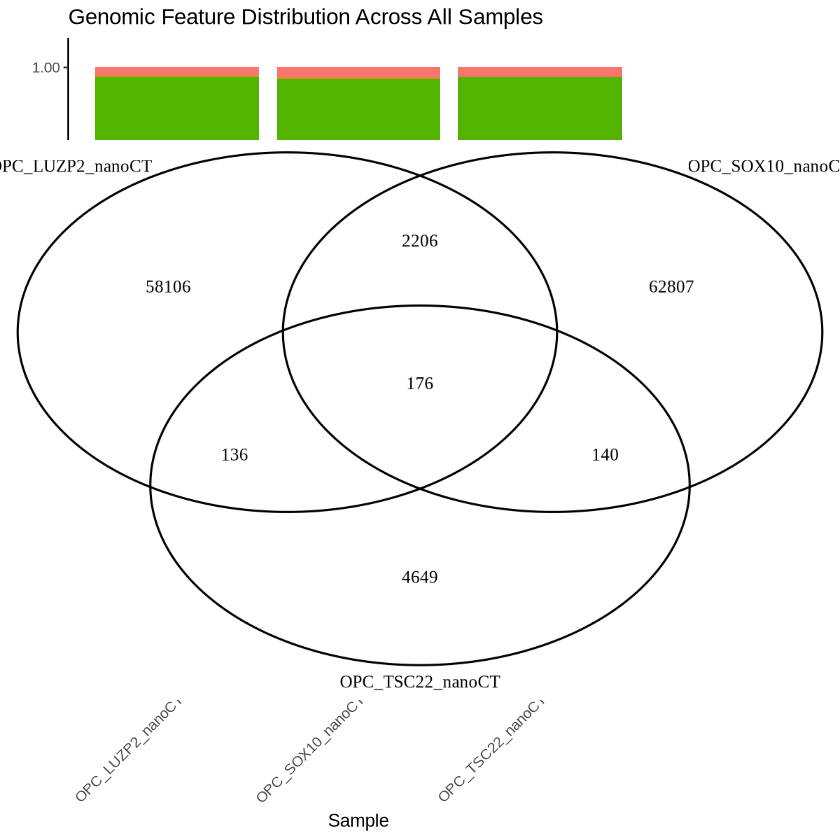

In [4]:
# ============================================================================
# Step 3: Create Visualizations of Genomic Feature Distribution
# ============================================================================
# These plots show WHERE peaks are located in the genome:
# - Promoters: regions near transcription start sites (TSS)
# - Exons: coding sequences
# - Introns: non-coding regions within genes
# - 3' UTR/5' UTR: untranslated regions
# - Intergenic: regions between genes
# - Distal Intergenic: far from genes

# Create individual pie charts for each sample showing feature distribution
for (s in names(feature_tables)) {
  ft <- feature_tables[[s]]

  # Create a pie chart showing the proportion of peaks in each genomic feature
  p <- ggplot(ft, aes(x = "", y = Freq, fill = Feature)) +
    geom_bar(stat = "identity", width = 1) +        # Create bars for the pie
    coord_polar("y") +                               # Convert to polar coordinates (pie chart)
    theme_void() +                                   # Use minimal theme for pie charts
    theme(legend.position = "right") +               # Show legend on the right
    ggtitle(paste0(s, " - Genomic Feature Distribution"))

  # Display the plot in notebook
  print(p)

  # Save the plot as a PNG image
  ggsave(filename = file.path(out_dir, paste0(s, "_feature_pie.png")),
         plot = p, width = 6, height = 4, dpi = 300)
}

# ============================================================================
# Combined Distribution Plot (All Samples)
# ============================================================================
combined <- bind_rows(lapply(names(feature_tables), function(n) {
  df <- feature_tables[[n]]
  df$Sample <- n  # Add sample name as a column
  df
}), .id = NULL)

# Create stacked bar chart showing feature distribution for each sample
p_all <- ggplot(combined, aes(x = Sample, y = Freq, fill = Feature)) +
  geom_bar(stat = "identity", position = "fill") +  # Stack bars (proportions sum to 1)
  theme_classic() +                                  # Clean, classic theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +  # Rotate x-axis labels
  labs(y = "Proportion",                             # Label the y-axis
       title = "Genomic Feature Distribution Across All Samples",
       x = "Sample")

# Display the plot in notebook
print(p_all)

# Save the combined plot
ggsave(file.path(out_dir, "all_samples_genomic_distribution.png"),
       p_all, width = 12, height = 6, dpi = 300)

# ============================================================================
# Venn diagram of peak overlaps (uses ChIPpeakAnno::makeVennDiagram)
# ============================================================================
# Generate a Venn diagram of overlapping peaks across samples and save/display it
if (length(peak_list) > 1) {
  if (!requireNamespace("png", quietly = TRUE)) message("Package 'png' not available to display images.")
  library(grid)

  # ChIPpeakAnno::makeVennDiagram expects a list of peak objects (GRanges or data.frames)
  peak_sets <- peak_list
  names(peak_sets) <- names(peak_list)

  venn_out <- tryCatch({
    png(file.path(out_dir, "peak_overlap_venn.png"), width = 1200, height = 800, res = 150)
    makeVennDiagram(peak_sets, NameOfPeaks = names(peak_sets))
    dev.off()
    TRUE
  }, error = function(e) {
    message("Venn diagram generation failed: ", e$message)
    try(dev.off(), silent = TRUE)
    FALSE
  })

  if (isTRUE(venn_out) && requireNamespace("png", quietly = TRUE)) {
    # Display the saved PNG inside the notebook
    img_path <- file.path(out_dir, "peak_overlap_venn.png")
    img <- png::readPNG(img_path)
    grid::grid.raster(img)
  } else if (isTRUE(venn_out)) {
    message("Venn PNG saved but package 'png' not available to display it here.")
  }
} else {
  message("Not enough samples for a Venn diagram (need >= 2).")
}

## Summary

In [5]:
# ============================================================================
# Step 4: Analyze Peak Overlaps Between Different Transcription Factors (TFs)
# ============================================================================
# This section identifies which peaks are:
# - Unique to each TF (found in one TF only)
# - Shared between TFs (found in multiple TFs)
# 
# This helps identify:
# - TF-specific regulatory elements
# - Commonly regulated genomic regions (suggesting cooperative binding)

# Extract sample names to organize overlap analysis
sample_names <- names(peak_list)

# Create a results table to store overlap information
overlap_results <- data.frame(
  Comparison = character(),
  Sample1 = character(),
  Sample2 = character(),
  Peaks_Sample1_Only = numeric(),
  Peaks_Sample2_Only = numeric(),
  Shared_Peaks = numeric(),
  stringsAsFactors = FALSE
)

# Compare each pair of samples
if (length(sample_names) > 1) {
  for (i in 1:(length(sample_names)-1)) {
    for (j in (i+1):length(sample_names)) {
      sample1 <- sample_names[i]
      sample2 <- sample_names[j]
      
      # Get peak sets for both samples
      peaks1 <- peak_list[[sample1]]
      peaks2 <- peak_list[[sample2]]
      
      # Find overlaps between the two peak sets
      # countOverlaps counts how many peaks from peaks2 overlap each peak in peaks1
      overlaps_1_2 <- countOverlaps(peaks1, peaks2, ignore.strand = TRUE)
      overlaps_2_1 <- countOverlaps(peaks2, peaks1, ignore.strand = TRUE)
      
      # Count peaks in different categories
      peaks1_unique <- sum(overlaps_1_2 == 0)    # Peaks only in sample1
      peaks2_unique <- sum(overlaps_2_1 == 0)    # Peaks only in sample2
      peaks_shared <- sum(overlaps_1_2 > 0)      # Peaks in sample1 that overlap sample2
      
      # Store results
      overlap_results <- rbind(overlap_results, data.frame(
        Comparison = paste0(sample1, " vs ", sample2),
        Sample1 = sample1,
        Sample2 = sample2,
        Peaks_Sample1_Only = peaks1_unique,
        Peaks_Sample2_Only = peaks2_unique,
        Shared_Peaks = peaks_shared,
        stringsAsFactors = FALSE
      ))
    }
  }
  
  # Save overlap analysis to Excel
  write.xlsx(overlap_results, file = file.path(out_dir, "peak_overlap_analysis.xlsx"))
  
  # Print overlap summary to console
  cat("\n========== PEAK OVERLAP ANALYSIS ==========\n")
  cat(sprintf("%-40s %15s %15s %15s\n", "Comparison", "Sample1-Only", "Sample2-Only", "Shared"))
  for (i in 1:nrow(overlap_results)) {
    cat(sprintf("%-40s %15d %15d %15d\n", 
                overlap_results$Comparison[i],
                overlap_results$Peaks_Sample1_Only[i],
                overlap_results$Peaks_Sample2_Only[i],
                overlap_results$Shared_Peaks[i]))
  }
  cat("==========================================\n\n")
}


========== PEAK OVERLAP ANALYSIS ==========
Comparison                                  Sample1-Only    Sample2-Only          Shared
OPC_LUZP2_nanoCT vs OPC_SOX10_nanoCT               58248           62949            2719
OPC_LUZP2_nanoCT vs OPC_TSC22_nanoCT               60529            4792             438
OPC_SOX10_nanoCT vs OPC_TSC22_nanoCT               65201            4786             448



In [6]:
# ============================================================================
# Step 5: Final Summary and Output Summary
# ============================================================================
# Print a summary of what was processed and where results were saved

cat("\n")
cat("========== ANALYSIS COMPLETE ==========\n")
cat(sprintf("Total narrowPeak files processed: %d\n", length(peak_files)))
cat(sprintf("Output directory: %s\n", out_dir))
cat("\nFiles generated:\n")
cat("  - *_annotated_peaks.xlsx: Full peak annotations with genomic features\n")
cat("  - *_GO_BP_enrichment.xlsx: Gene Ontology Biological Process results\n")
cat("  - *_KEGG_enrichment.xlsx: KEGG pathway enrichment results\n")
cat("  - *_feature_pie.png: Pie charts of genomic feature distribution\n")
cat("  - *_GO_BP_dotplot.png: Visualization of GO term enrichment\n")
cat("  - *_GO_BP_barplot.png: Bar chart of top enriched GO terms\n")
cat("  - *_KEGG_dotplot.png: Visualization of KEGG pathway enrichment\n")
cat("  - peak_overlap_analysis.xlsx: Overlap analysis between TF samples\n")
cat("  - all_samples_genomic_distribution.png: Comparison of feature distributions\n")
cat("========================================\n\n")

invisible(NULL)

========== ANALYSIS COMPLETE ==========


Total narrowPeak files processed: 3


Output directory: /cfs/klemming/projects/supr/uppstore2017150/Mattia/Analysis



Files generated:


  - *_annotated_peaks.xlsx: Full peak annotations with genomic features


  - *_GO_BP_enrichment.xlsx: Gene Ontology Biological Process results


  - *_KEGG_enrichment.xlsx: KEGG pathway enrichment results


  - *_feature_pie.png: Pie charts of genomic feature distribution


  - *_GO_BP_dotplot.png: Visualization of GO term enrichment


  - *_GO_BP_barplot.png: Bar chart of top enriched GO terms


  - *_KEGG_dotplot.png: Visualization of KEGG pathway enrichment


  - peak_overlap_analysis.xlsx: Overlap analysis between TF samples


  - all_samples_genomic_distribution.png: Comparison of feature distributions


# Analysis Overview

## What This Notebook Does

This notebook performs a comprehensive analysis of BAMPE (paired-end BAM format) peak files from MACS3 peak caller:

1. **Reads narrowPeak files** - Loads and processes peak calls from your BAMPE samples
2. **Annotates peaks to genes** - Uses ChIPseeker to assign each peak to the nearest gene and identify genomic feature (promoter, exon, etc.)
3. **Functional enrichment** - Analyzes Gene Ontology (GO) and KEGG pathways for genes with peaks
4. **Creates visualizations** - Generates pie charts and enrichment plots
5. **Compares samples** - Identifies shared and unique peaks between different transcription factors

## Key Concepts for Beginners

- **narrowPeak file**: Text file output from MACS3 containing peak locations and quality metrics
- **Annotation**: Assigning genomic meanings to peaks (e.g., "this peak is in a promoter region")
- **Enrichment**: Statistical test to find over-represented biological terms (GO, KEGG) in genes with peaks
- **Feature types**: 
  - Promoter: region near transcription start site where RNA polymerase binds
  - Exon: protein-coding region
  - Intron: non-coding region within a gene
  - UTR: untranslated region (not translated to protein)
  - Intergenic: between genes

## Customization

- **Change genome**: Edit `genome <- "hg38"` to `"mm10"` for mouse data
- **Adjust TSS region**: Modify `tssRegion = c(-3000, 3000)` to change promoter definition
- **Modify p-value cutoffs**: Change `pvalueCutoff` for more/less stringent enrichment results
- **Change plot colors**: Edit color schemes in ggplot2 commands

## Notes

- Requires conda environment `bampe_analysis` with all packages installed
- All results saved to: `/cfs/klemming/projects/supr/uppstore2017150/Mattia/Analysis/`
- Processing time depends on number and size of peak files